# Airbnb: From stars to sentiments

## Executive summary

Recommendation systems have been highly popularized during the past few years by companies like Netflix, Amazon and Airbnb, who have been using these systems in their platforms to provide a better customer experience and improve their sales and revenue. 

Some of these organizations have been using collaborative base recommendation systems based on ratings like, the number of stars. However, customers nowadays are more critical at the moment of evaluating products and services. They require more information to take a decision. This is especially important for e-commerce platforms like Lazada and Amazon where customers take important consideration on the reviews of other people in both images and comments to get an understanding about the credibility and quality of a product. 

For this project, I am seeking to solve the question of how we can utilize reviews and comments from other customers to generate a recommendation system instead of using the usual ratings or number of stars. 

In this project, I will be using the data of Airbnb reviews for Singapore which include text reviews of the places where people have stayed. I will be extracting the sentiments of the reviews and will be using them as a metric of the product quality. The sentiment will be extracted with Vader or Valence Aware Dictionary for Sentiment Reasoning, which uses a Dictionary for both extracting the polarity and intensity of a text. 

Then, I will use the Surprise library to generate the recommendation system. Different models will be implemented like SVD, KNN based methods and others to identify what will provide a better result. 

My project provided best results using algorithms like SVD, SVD++ and BaselineOnly based on metrics like MAE and RMSE. K nearest neighbors algorithms were not a great option because of the computation complexity of the algorithm. I still recommend to take a look into this models with other datasets with more reviews per user. However, since we are using the airbnb dataset where there are few reviews per user, other models are preffered.

In [1]:
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from surprise import *
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gvmm0jt0 because the default path (/home/awhite/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Introduction

Airbnb is, with no doubt, one of the most important platforms in the travel and recreation space right now. With its revolutionary business model, Airbnb has been able to transform the travel industry- this is by providing users with a new option of accommodations for travelers that do not want to spend a forture in big hotel chains but at the same time, do not want to sacrifice the commodity and cleanliness of their stay. Other companies have entered into similar segments of the travel industry by recommending hotels and other accomodations like Trivago, Booking.com and Hostel World. However, none of them have been as successful as Airbnb in both generating revenue and quantity of users. 

A core part of Airbnb is the quality of the service and its excellent recommendation system. Airbnb is generally very good at recommending stays that are similar to the users query based on simple filters like location and price. However, nowadays many users need more information to take a decision of where to stay. Ratings have been probably one of the most frequently used ways to provide feedback of the quality of a service or product and have been effectively used in Airbnb. But similar to e-commerce, quality metrics based on ratings can be biased, incomplete or manipulated. Because of this reason, many users are looking nowadays at reviews and comments from guests where they can understand more in detail the reasons behind a specific rating. 

Because of this reason, I seek to answer the question: "how can we take into consideration the user reviews and comments of a specific stay to generate a recommendation system?" By using Natural Language Processing, we can extract important information about the content of a text. In this case, I decided to extract the sentiment using VADER, a popular sentiment analysis pretrained model. 

## Dataset

The dataset used was obtained from the public library available in jojie, which contains a total of 95,322 reviews made by a total of 87,908 total reviewers in 4,576 unique listings from Singapore. The data was collected from 2013 to 2020. The reviews are fairly clean as they do not contain missing values. However, many of the comments are automatically generated by the airbnb platform or were created in different languages - this is the reason why I decided to exclude them for this project as it did not provide any valuable information about the sentiment of a the stay of a user. 

Let's start by importing the data:

In [2]:
df_reviews = pd.read_csv('/mnt/data/public/insideairbnb/data.insideairbnb.com\
/singapore/sg/singapore/2020-04-26/data/reviews.csv.gz', compression='gzip')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am..."


Lets take a look to a review:

In [3]:
df_reviews.comments[0]

'Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.'

Lets find out how balanced is the dataset:

In [4]:
u, c  = np.unique(df_reviews.groupby('reviewer_id').count()['listing_id'].values, return_counts = True)
u,c

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 18]),
 array([82491,  4310,   709,   216,    82,    38,    20,    15,     7,
            6,     3,     2,     2,     5,     2]))

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Reviews per user'), Text(0, 0.5, 'Users')]

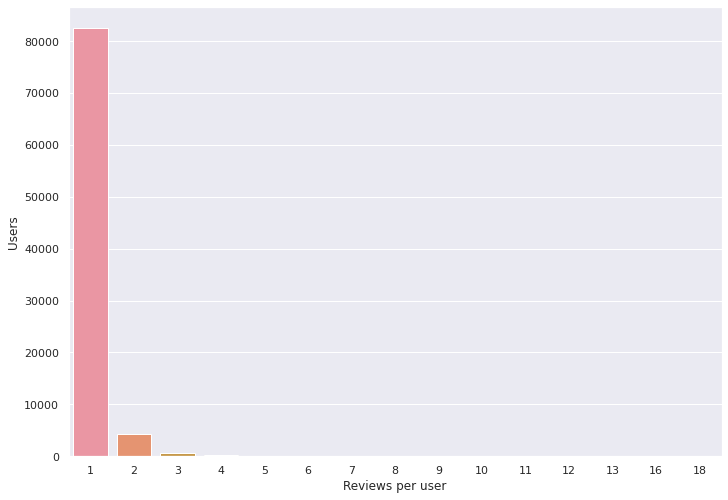

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(u,c)
ax.set(xlabel='Reviews per user', ylabel='Users')

Based on this, it is possible to notice that the dataset is highly unbalanced and biased to customers providing only 1 or 2 reviews. This might present a challenge for some algorithms like KNN as they use similar content from users to provide a recommendation. However, as many users only have 1 review, the recommendation system may fail to provide a recommendation. This information can guide us to use other models and techniques.

## Sentiment Analysis

I am now going to perform the sentiment extraction of the comments using Vader. Vader generates different values from each text like how positive, negative or neutral it is. As well, I have a compound option that generates an approximation of the sentiment using all the other features. For this project, I will use compound as it includes positive and negative sentiments in a compound matter.

In [6]:
analyser = SentimentIntensityAnalyzer()

In [7]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']


In [8]:
sentiment = []
for c in tqdm(df_reviews['comments'].values):
    sentiment.append(sentiment_analyzer_scores(str(c)))

100%|██████████| 95322/95322 [00:38<00:00, 2453.86it/s]


In [9]:
df_reviews['sentiment'] = sentiment
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,0.9615
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...,0.9484
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,0.9881
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,0.9627
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am...",0.9274


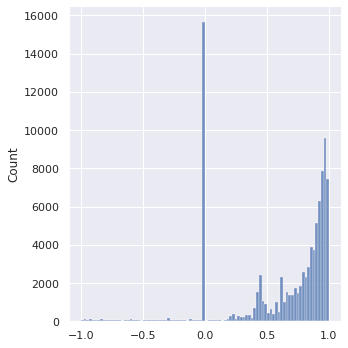

In [10]:
sns.set(rc={'figure.figsize':(2,2)})
ax = sns.displot(sentiment)

We can see that the the majority of the reviews are positive and closer to 1 which can be explained due to the quality controls of Airbnb However there is a pecularity with reviews with the sentiment equal to 0. 

Lets take a closer review to these items:

In [11]:
df_reviews.loc[df_reviews['sentiment'] == 0.]['comments']

25       The reservation was canceled 38 days before ar...
47       預定兩間房六人入住兩天~一間房間有雙人床及單人床,另一間卻是雙人床和一壞掉床架在用釘上木板,...
50       The host canceled this reservation 123 days be...
52                                出行方便,房东人非常好｡也很热情｡是个不错的选择
57                             It has everything you need.
                               ...                        
95284                                                    .
95289    Really comfy room and overall experience. Look...
95310    Room was advertised with a window, there was not!
95312    The host canceled this reservation 7 days befo...
95317                            Next time will come again
Name: comments, Length: 15637, dtype: object

After taking a look to some of these items we can see that many of the reviews are automatically generated by the airbnb system or are in different languages. Based on this, I will delete data of comments with sentiment equal to 0. As well, I will prepare the data in a format which will be accepted in the surprise library. 

In [12]:
idx = df_reviews.loc[df_reviews['sentiment'] == 0.]['comments'].index
df_reviews = df_reviews.drop(index = idx)

In [13]:
df_short = df_reviews[['reviewer_id', 'listing_id', 'sentiment']]
df_short.head()

,reviewer_id,listing_id,sentiment
0,8557223,49091,0.9615
1,1356099,50646,0.9484
2,15222393,50646,0.9881
3,5543172,50646,0.9627
4,817532,50646,0.9274


## Recommendation System 

The recommendation system will be done with the surprise library. First, we have to create a reader function which contains the scale of the sentiment to be used. The sentiments are generated from -1 to 1 where values near to -1 are negative sentiment, and near to 1 are positive. As well, we will be importing the dataframe with the Dataset function from Surprise. 

In [14]:
reader = Reader(rating_scale=(-1, 1))
data = Dataset.load_from_df(df_short, reader)

To identify the best model, we will use an interative process with crossvalidation and we will determine the best model by different measures like RMSE and MAE. It is important to mention that K-nearest neighbor models were used. However, we were not successful in providing results. A potential reason for this is the high sparcity of the matrix, where majority of users only have 1 review which makes the model not ideal to run.  

In [15]:
benchmark = []
# Iterate over all algorithms
for algorithm in tqdm([SVD(), SVDpp(), 
                       NormalPredictor(), 
                       #KNNBaseline(k = 5), 
                       #KNNBasic(k = 5), 
                       #KNNWithMeans(k = 5), 
                       #KNNWithZScore(k = 5), 
                       BaselineOnly(), 
                       CoClustering()]):
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=2, 
                             verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], 
                               index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

 60%|██████    | 3/5 [00:18<00:11,  5.96s/it]

Estimating biases using als...
Estimating biases using als...


100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly,0.315069,0.205046,0.145757,0.324808
SVDpp,0.315851,0.205753,4.846539,0.409469
SVD,0.316708,0.205838,2.814932,0.282941
CoClustering,0.387877,0.262832,4.137002,0.258637
NormalPredictor,0.417303,0.299625,0.060083,0.474427


Based on these results, the SVD model, SVD++ and BaselineOnly provided the best results in test time, RMSE and MAE scores. However SVD have been fairly most implemented in text recommendation systems. As described by Nikolenko et al. in "SVD-LDA: topic modelling for Full-text recommender system" which showed significant improvement in the text recommendation system after doing SVD and LSA. 

Because of this an other research in the Area I decided to proceed with SVD model. 

In [16]:
from surprise import SVD,NormalPredictor
from surprise.model_selection import GridSearchCV

In [17]:
param_grid = {'n_factors':[50,100,150],'n_epochs':[10,20,30],  'lr_all':[0.001,0.005,0.01],'reg_all':[0.01,0.02,0.05]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)
gs.fit(data)
params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])
               

In [18]:
gs.best_score['rmse']

0.3159155418370166

In [19]:
params

{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.05}

The best model using gridsearch and SVD have an RMSE of 0.31. Now we can use this to create a funciton to predict the closest items only based on sentiments extracted from the reviews. 

## Generating predictions

We will generate the top 10 recommendations of where to stay for a specific user only based on the sentiment extracted from the customer reviews. For this we will use the SVD model with the hyperoptimized parameters from the grid search result. 

In [20]:
def svd_recommend(df, user):
    """finds and returns the top 10 similar items with SVD latent factor model"""
    
    reader = Reader(rating_scale = (-1,1))
    dataset = Dataset.load_from_df(df, reader).build_full_trainset()
    
    
    algo = SVD(n_factors= 50, n_epochs= 10, lr_all= 0.005, reg_all= 0.05)
    algo.fit(dataset)
    pred = []
    
    for i in set(df["listing_id"]) - set(df.loc[df['reviewer_id'] == user]['listing_id']):
        
        pred.append(algo.predict(uid = user, iid = i))
        
        
    return [i[1] for i in sorted(pred, key = lambda x:-x[3])[:10]]


In [21]:
closest_listings = svd_recommend(df_short, 8557223)

Lets take a look to the 10 listings with closest sentiment values:

In [22]:
df_short[df_short['listing_id'].isin(closest_listings)].groupby('listing_id').mean()['sentiment']

listing_id
764599      0.882954
7697928     0.951545
7791384     0.920581
16010059    0.949700
16460492    0.843243
18000521    0.894067
21370642    0.882617
31081282    0.962500
34214140    0.846900
40935010    0.836025
Name: sentiment, dtype: float64

In [23]:
df_reviews[df_reviews['listing_id'].isin(closest_listings)][['comments']][:10]

,comments
1893,"Christeena is really nice to be with, and her ..."
1894,I booked Chreestina's place for a friend and h...
1895,I had a lovely stay with Christeena and her ad...
1896,Its been wonderful staying at Christeena's pla...
1897,I had a great stay with Christeena. This was t...
1898,"Very lucky to live Christeena home, make my tr..."
1899,"크리스티나랑 토마스 모두 친절했어요. 토마스는 재치가 있어서 더 좋았구, 그곳에서 ..."
1900,"Christeena is the best host I have ever met , ..."
1902,So nice
1903,The room is clean like in the picture. Have a ...


After doing a quick inspection we can notice that the majority of the recommended listings have similar sentiments of the reviews from the users. This is fairly the behaviour we were expecting from our recommendation system. 

## Conclusions and Recommendations

The results of using the sentiment of reviews in a recommendation system is fairly favorable, however we notice that there are plenty of limitations. The first limitation of course is the type of data. For datasets like Airbnb where customer review a small number of stays, it would be challenging to optimize a recommendation model. Another limitation is the language of the reviews as many of the available pre-trained models are usually in english. This might require an in house NLP model to extract the sentiments in different languages which will be limited by the number of reviews. 

Another important consideration is the preprocessing and cleaning of data. Even if this dataset was fairly clean, some times we will need to evaluate what content to use and what to avoid. This might come from a deep analysis and understanding of the problem. 

In general we think the results are positive and sentiment analysis can be an aditional tool to help generating valuable content for users. Other language modeling method can be recommended to explore as topic modeling. We also recommend to replicate this type of study in other type of datasets with more reviews per users. 

Even if we think sentiment analysis is a worth endeavour for recommendation systems, we also think a recommendation system only based in sentiments is not enough. Sentiment can be use with other type of content to generate a content based recommendation system. 

Vader provided fairly good and accurate results, however many other NLP models and techniques for sentiment analysis can be used to improve the model. Other considerations can be taken for example deleting stopwords and other text preprocessing.


## Bibliography

Nikolenko, S. SVD-LDA: Topic Modeling for Full-Text Recommender Systems. Springer Link. https://link.springer.com/chapter/10.1007/978-3-319-27101-9_5

Chandarana, N. SVD: Where Model Tuning Goes Wrong. https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

Li, s. Building and Testing Recommender Systems With Surprise, Step-By-Step. https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
